In [1]:
%matplotlib inline
import calendar
import configparser
import glob
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Get API key for HydAPI
api_key = nivapy.da.authenticate_nve_hydapi()

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# Update RID flow datasets

Each year, updated flow datasets (both modelled and observed) are obtained from NVE and added to RESA2.

In [3]:
# Year of interest
year = 2022

## 1. Observed discharge

Observed time series are used **only** for the 11 main rivers - all other calculations are based on modelled flows (from HBV). This notebook uses NVE's HydAPI to download data for the relevant stations where possible. Other datasets must be obtained directly from NVE (e-mail Trine Fjeldstad). Note that more than 11 discharge stations are involved, because at some chemistry sampling locations the flow is the sum of several NVE discharge series. Note also the following:

 * Chemistry station 29613 should ideally use the sum of NVE series 16.133 and 16.153, but the latter is no longer available. We simply assume the input from 16.153 is constant at 10 $m^3/s$ (which is roughly equal to the long-term average) <br><br>
 
 * The discharge for chemistry station 29614 is **either** NVE station 21.71 **or** 21.11. 21.11 is usually available first, but can check 21.71 too <br><br> 
 
 * Discharge data for chemistry stations 29617 (NVE ID 2.605) and 36225 (NVE ID 6.78) are often delayed. Need to contact Trine at NVE early to avoid problems later.
 
**Added 07.09.2023:** The observed data for Alna come from Oslo VAV and are often delayed. Given MDir's new reporting deadline, we have decided to switch to using modelled data from NVE for this site instead. This simply involves changing the default discharge station in RESA for site 36225 from `dis_station_id` 626 (which is the Oslo VAV dataset) to 283 (which is the NVE modellled dataset). See the notebook `compare_alna_discharge.ipynb` and the e-mail from Øyvind received 07.09.2023 for details.

### 1.1. Discharge stations

The discharge stations associated with 10 of the 11 main water chemistry sampling locations are shown in the dataframe below. Alna now uses modelled data (see above)

In [4]:
xl_path = r"../data/rid_resa_nve_discharge_stations.xlsx"
resa_nve_df = pd.read_excel(xl_path, sheet_name="observed_stns")
resa_nve_df.dropna(subset="nve_id", inplace=True)

with pd.option_context("display.max_colwidth", None):
    display(resa_nve_df)

,station_id,station_code,nve_id,dis_station_id,comment
0,29612,BUSEDRA,12.285.0,57.0,Not available via API
1,29613,TELESKI,16.133.0,59.0,"Actually (16.153 + 16.133), but 16.153 no longer monitored. Assume constant at 10 m3/s and add to 16.133"
2,29614,VAGEOTR,21.11.0,487.0,Not available via API
3,29615,VESENUM,15.61.0,58.0,NaN
4,29617,ØSTEGLO,2.605.0,56.0,NaN
5,29778,STREORK,121.22.0,348.0,NaN
6,29779,FINEALT,212.11.0,386.0,NaN
7,29782,NOREVEF,151.28.0,351.0,"Used to be 151.5.0, but this is not available via API. 151.28.0 seems identical"
8,29783,ROGEORR,28.7.0,355.0,NaN
9,29821,HOREVOS,62.5.0,546.0,NaN


### 1.2. Data from HydAPI

In [5]:
# Get stations from HydAPI
nve_stn_df = nivapy.da.get_nve_hydapi_stations(api_key=api_key)
nve_stn_ids = resa_nve_df["nve_id"].values
nve_stn_df = nve_stn_df.query("station_id in @nve_stn_ids")
print(f"{len(nve_stn_df)} out of {len(resa_nve_df)} stations found in HydAPI:")
nve_stn_df

10 out of 10 stations found in HydAPI:


,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
144,12.285.0,Døvikfoss,59.88624,9.90977,215291,6649693,19,Drammensvassdraget,3047,Modum,...,1310.0000,1510.0000,1670.0000,2030.0000,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Driftsvannføring', 'parame..."
224,121.22.0,Syrstad,63.03225,9.72771,233461,7000123,147,Orkla,5059,Orkland,...,448.0000,520.0000,788.0000,1043.0000,2.4200,2.8700,3.1600,4.1400,4.9500,"[{'parameterName': 'Vannstand', 'parameter': 1..."
379,15.61.0,Holmfoss i Numedalslågen,59.18906,9.99414,214153,6571840,20,Numedalslågen,3805,Larvik,...,557.7559,666.5267,784.6265,960.4094,4.9316,5.3693,5.7934,6.2009,6.7331,"[{'parameterName': 'Vannstand', 'parameter': 1..."
388,151.28.0,Laksfors,65.62155,13.29156,421320,7278797,40,Vefsna,1825,Grane,...,1266.0000,1427.0000,1580.0000,1779.0000,4.7400,5.1500,5.4300,5.6900,5.9900,"[{'parameterName': 'Vannstand', 'parameter': 1..."
461,16.133.0,Skotfoss,59.20771,9.52788,187736,6576005,16,Skiensvassdraget,3807,Skien,...,920.0000,1070.0000,1210.0000,1400.0000,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannføring', 'parameter': ..."
871,2.605.0,Solbergfoss,59.63733,11.15354,283189,6617306,98,Glommavassdraget,3014,Indre Østfold,...,2677.0000,3046.0000,3217.0000,3492.0000,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannføring', 'parameter': ..."
981,21.11.0,Heisel,58.24755,7.95144,86711,6477930,19,Otra,4223,Vennesla,...,731.0178,871.0733,1004.6568,1176.4673,4.9153,5.6985,6.2775,6.7984,7.4321,"[{'parameterName': 'Lufttemperatur', 'paramete..."
1022,212.11.0,Kista,69.82630,23.51681,826880,7769359,62,Altavassdraget,5403,Alta,...,888.8162,1014.6972,1119.2831,1234.5527,3.5130,4.0487,4.3299,4.5492,4.7781,"[{'parameterName': 'Vannstand', 'parameter': 1..."
1187,28.7.0,Haugland,58.69291,5.64757,-40981,6543711,19,Hååna,1121,Time,...,88.1993,101.5965,114.6455,131.8289,1.7366,1.8855,1.9995,2.1025,2.2285,"[{'parameterName': 'Vannstand', 'parameter': 1..."
1433,62.5.0,Bulken (Vangsvatnet),60.62868,6.29254,24518,6753006,51,Vossovassdraget,4621,Voss,...,470.0000,530.0000,580.0000,660.0000,3.6800,4.2700,4.7700,5.1800,5.8300,"[{'parameterName': 'Vannstand', 'parameter': 1..."


In [6]:
# Get discharge
par_ids = [1001]
st_dt = f"{year}-01-01"
end_dt = f"{year + 1}-01-01"
q_df = nivapy.da.query_nve_hydapi(
    nve_stn_ids, par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-01 11:00:00+00:00,156.9264,m³/s,0,2
1,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-02 11:00:00+00:00,158.2565,m³/s,0,2
2,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-03 11:00:00+00:00,196.2556,m³/s,0,2
3,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-04 11:00:00+00:00,247.2379,m³/s,0,2
4,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-05 11:00:00+00:00,250.3433,m³/s,0,2


In [9]:
# Check number of records as expected
days = 366 if calendar.isleap(year) else 365
# assert len(q_df) == len(nve_stn_df) * days, "Number of records is not as expected."

# Check quality control level
print(
    "The following series have not completed quality control and will be dropped (i.e. 'quality' < 3;"
)
print("see https://hydapi.nve.no/UserDocumentation/ for details):\n")
print(q_df.query("quality != 3")[["station_id", "station_name"]].drop_duplicates())

# Drop quality < 3
q_df = q_df.query("quality == 3")

# Check for NaN
if pd.isna(q_df["value"]).sum() > 0:
    print("\n\nThe following records contain NaN values:\n")
    print(
        q_df[pd.isna(q_df["value"])][["station_id", "station_name"]].drop_duplicates()
    )

# Check for negative
if (q_df["value"] < 0).sum() > 0:
    print("\n\nThe following records contain values <0:\n")
    print(q_df[q_df["value"] < 0][["station_id", "station_name"]].drop_duplicates())

The following series have not completed quality control and will be dropped (i.e. 'quality' < 3;
see https://hydapi.nve.no/UserDocumentation/ for details):

     station_id station_name
0      16.133.0     Skotfoss
2555    2.605.0  Solbergfoss


Based on the output above we can **make a data request to NVE**. This typically involves requesting the records for stations **21.11.0** and **12.285.0** (which are not available via HydAPI), **plus** any sites that haven't yet finished quality control (listed above).

The cell below uploads the valid HydAPI data to RESA2.

In [10]:
def process_hydapi_data_for_resa(resa_nve_df, q_df, eng):
    """Process discharge time series from HydAPI and prepare them for upload to RESA2.

    Args
        resa_nve_df: Dataframe of RESA stations with NVE IDs
        q_df:        Dataframe of discharge data from HydAPI
        eng:         Obj. Active database connection object for RESA2

    Returns
        Dataframe.
    """
    df_list = []

    # Loop over Hydra II data
    for idx, row in resa_nve_df.iterrows():
        nve_id = row["nve_id"]
        dis_stn_id = row["dis_station_id"]

        # Get flow for station
        q_stn_df = q_df.query("station_id == @nve_id").copy()

        if len(q_stn_df) == 0:
            print(f"No data for NVE ID {nve_id}.")

        else:
            assert len(q_stn_df) == days

            # Remove HH:MM:SS part from dates
            q_stn_df.set_index("datetime", inplace=True)
            q_stn_df = q_stn_df.resample("D").mean(numeric_only=True)
            q_stn_df.reset_index(inplace=True)
            q_stn_df["datetime"] = q_stn_df["datetime"].dt.date

            # Linear interpolation and back-filling of NaN
            q_stn_df["value"].interpolate(method="linear", inplace=True)
            q_stn_df["value"].fillna(method="backfill", inplace=True)

            # Add 10 m3/s to 16.133 (RESA2 discharge station ID 59)
            if dis_stn_id == 59:
                q_stn_df["value"] = q_stn_df["value"] + 10

            # Add other required cols and tidy
            q_stn_df["dis_station_id"] = dis_stn_id
            q_stn_df["xcomment"] = np.nan
            q_stn_df["xvalue"] = q_stn_df["value"]
            q_stn_df["xdate"] = q_stn_df["datetime"]

            # Reorder cols
            q_stn_df = q_stn_df[["dis_station_id", "xdate", "xvalue", "xcomment"]]

            # Append to output
            df_list.append(q_stn_df)

            # Check whether data already exist for this year
            sql = (
                "SELECT count(*) FROM resa2.discharge_values "
                "WHERE dis_station_id = %s "
                "AND EXTRACT(YEAR FROM xdate) = %s " % (dis_stn_id, year)
            )
            cnt_df = pd.read_sql(sql, eng)
            cnt = cnt_df.iloc[0, 0]
            if cnt > 0:
                print(
                    "%s data already exist for NVE "
                    "station %s (RESA2 ID %s)." % (cnt, nve_id, dis_stn_id)
                )

    hydapi_q_df = pd.concat(df_list, axis=0)

    return hydapi_q_df

In [11]:
hydapi_q_df = process_hydapi_data_for_resa(resa_nve_df, q_df, eng)
hydapi_q_df.head()

No data for NVE ID 12.285.0.
No data for NVE ID 16.133.0.
No data for NVE ID 21.11.0.
365 data already exist for NVE station 15.61.0 (RESA2 ID 58.0).
No data for NVE ID 2.605.0.
365 data already exist for NVE station 121.22.0 (RESA2 ID 348.0).
365 data already exist for NVE station 212.11.0 (RESA2 ID 386.0).
365 data already exist for NVE station 151.28.0 (RESA2 ID 351.0).
365 data already exist for NVE station 28.7.0 (RESA2 ID 355.0).
365 data already exist for NVE station 62.5.0 (RESA2 ID 546.0).


,dis_station_id,xdate,xvalue,xcomment
0,58.0,2022-01-01,64.88686,NaN
1,58.0,2022-01-02,52.40464,NaN
2,58.0,2022-01-03,57.78065,NaN
3,58.0,2022-01-04,56.52222,NaN
4,58.0,2022-01-05,53.56106,NaN


In [ ]:
# # Add new rows to database
# hydapi_q_df.to_sql(
#     "discharge_values", con=eng, schema="resa2", if_exists="append", index=False
# )

### 1.3. Data from Trine

Once all the missing datasets identified above have been obtained from NVE, the following code can be used to add them to the database.

In [12]:
# Folder containing data from Trine
tri_fold = f"/home/jovyan/shared/common/elveovervakingsprogrammet/nve_observed/{year}-{year - 1999}"

days = 366 if calendar.isleap(year) else 365

# List to store output
df_list = []

# Get list of files from Trine to process
search_path = os.path.join(tri_fold, "*.csv")
file_list = glob.glob(search_path)

# Loop over files from Trine
for file_path in file_list:
    # Get RESA station ID
    nve_id = os.path.split(file_path)[1].split("_")[0] + ".0"
    dis_stn_id = resa_nve_df.query("nve_id == @nve_id")["dis_station_id"].iloc[0]

    # Parse file
    q_stn_df = pd.read_csv(
        file_path,
        skiprows=1,
        index_col=0,
        parse_dates=True,
        header=None,
        sep=";",
        names=["xdate", "xvalue"],
        na_values="-9999",
        encoding="cp1252",
    )

    # Get just records for year of interest
    q_stn_df = q_stn_df.truncate(before="%s-01-01" % year, after="%s-12-31" % (year))

    # Remove HH:MM:SS part from dates
    q_stn_df = q_stn_df.resample("D").mean(numeric_only=True)
    q_stn_df.reset_index(inplace=True)
    q_stn_df["xdate"] = q_stn_df["xdate"].dt.date

    # Linear interpolation and back-filling of NaN
    q_stn_df["xvalue"].interpolate(method="linear", inplace=True)
    q_stn_df["xvalue"].fillna(method="backfill", inplace=True)

    # Add 10 m3/s to 16.133 (RESA2 ID 59)
    if dis_stn_id == 59:
        q_stn_df["xvalue"] = q_stn_df["xvalue"] + 10.0

    # Add dis_id and tidy
    q_stn_df["dis_station_id"] = dis_stn_id
    q_stn_df["xcomment"] = np.nan

    # Reorder cols
    q_stn_df = q_stn_df[["dis_station_id", "xdate", "xvalue", "xcomment"]]

    # Append to output
    df_list.append(q_stn_df)

# Stack data
tri_q_df = pd.concat(df_list, axis=0)

assert (
    len(tri_q_df) == len(file_list) * days
), "Datasets has an unexpected number of records."
assert tri_q_df["xvalue"].dtypes == np.float64, 'Check for text in "xvalue" column.'
assert pd.isna(tri_q_df["xvalue"]).sum() == 0, 'Check for NaN in "xvalue" column.'

tri_q_df.head()

,dis_station_id,xdate,xvalue,xcomment
0,487.0,2022-01-01,134.790000,NaN
1,487.0,2022-01-02,120.004167,NaN
2,487.0,2022-01-03,123.886250,NaN
3,487.0,2022-01-04,124.892500,NaN
4,487.0,2022-01-05,101.429583,NaN


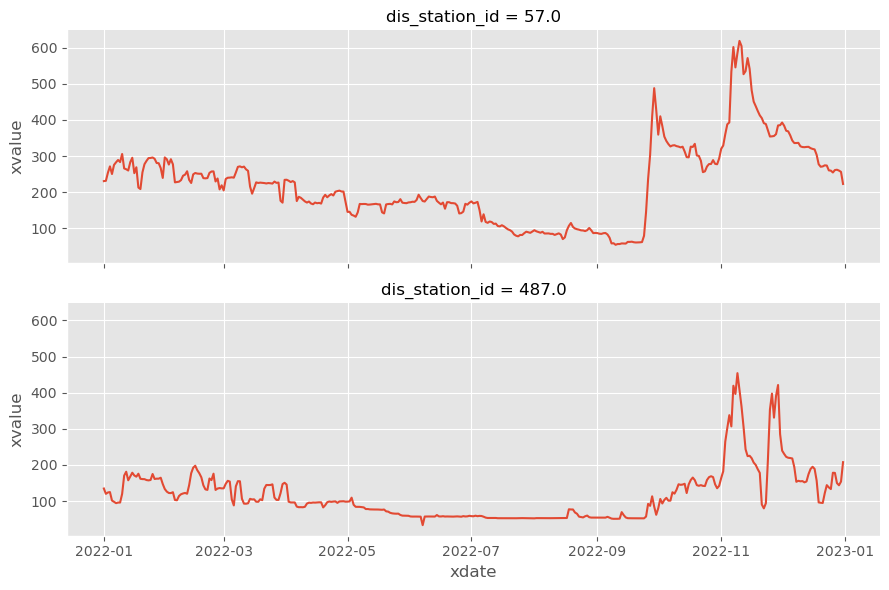

In [13]:
sn.relplot(
    data=tri_q_df,
    x="xdate",
    y="xvalue",
    row="dis_station_id",
    kind="line",
    height=3,
    aspect=3,
)

In [14]:
# # Add new rows to database
# tri_q_df.to_sql(
#     "discharge_values", con=eng, schema="resa2", if_exists="append", index=False
# )

730

## 2. Modelled discharge

Each year, Stein Beldring supplies modelled data from HBV for the period from 1990 to the year of interest. The flow files are named e.g. `hbv_00000001.var`, where the number corresponds to the NVE "vassdragsområde". These are listed in *vassomr.pdf* in the above folder, and they're also included in RESA2's `DISCHARGE_STATIONS` table. The vassdragsområde numbers are stored in the `NVE_SERINUMMER` field.

Tore has an Access database in e.g.

K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\Vannføring\Modellert\NVE_MODELLERT_2016\vannføring

that first deletes the modelled NVE values for each station from 1990 onwards and then adds the new data, which includes everything from 1990 plus the additional year of data. The code below does the same, and performs some basic checking of the data at the same time.

In [18]:
# Folder containing modelled data
data_fold = (
    f"/home/jovyan/shared/common/elveovervakingsprogrammet/nve_hbv_modelled/nve_rid_{year}"
)

# Get a list of files to process (only interested in flow here)
search_path = os.path.join(data_fold, "hbv_*.var")
file_list = glob.glob(search_path)

# Get number of days between 1990 and year of interest
days_new = len(pd.date_range(start="1990-01-01", end="%s-12-31" % year, freq="D"))

# Get number of days between 1990 and year before
days_old = len(pd.date_range(start="1990-01-01", end="%s-12-31" % (year - 1), freq="D"))

# Loop over files
for file_path in file_list:
    # Get name and reg. nr.
    name = os.path.split(file_path)[1]
    reg_nr = int(name.split("_")[1][:-4])
    print(f"Processing {name}.")

    # Get RESA2 station ID
    sql = (
        "SELECT dis_station_id FROM resa2.discharge_stations "
        "WHERE nve_serienummer = '%s'" % reg_nr
    )
    dis_id = pd.read_sql_query(sql, eng).iloc[0, 0]

    # Check number of post-1990 records already in db
    # (should equal days_old)
    sql = (
        "SELECT COUNT(*) FROM resa2.discharge_values "
        "WHERE dis_station_id = %s "
        "AND xdate >= DATE '1990-01-01'" % dis_id
    )
    cnt_old = pd.read_sql_query(sql, eng).iloc[0, 0]
    assert cnt_old == days_old, "Unexpected number of records already in database."

    # Read new data
    df = pd.read_csv(
        file_path, delim_whitespace=True, header=None, names=["XDATE", "XVALUE"]
    )

    # Convert dates
    df["XDATE"] = pd.to_datetime(df["XDATE"], format="%Y%m%d/1200")

    # Check st, end and length
    assert df["XDATE"].iloc[0] == pd.Timestamp(
        "1990-01-01"
    ), "New series does not start on 01/01/1990."
    assert df["XDATE"].iloc[-1] == pd.Timestamp("%s-12-31" % year), (
        "New series does not end on 31/12/%s." % year
    )
    assert len(df) == days_new, "Unexpected length for new series."

    # Add station ID to df
    df["DIS_STATION_ID"] = dis_id

#     # Drop existing rows post-1990 for this site
#     sql = (
#         "DELETE FROM resa2.discharge_values "
#         "WHERE dis_station_id = %s "
#         "AND xdate >= DATE '1990-01-01'" % dis_id
#     )
#     res = eng.execute(sql)

#     # Add new rows
#     df.to_sql(
#         "discharge_values", con=eng, schema="resa2", if_exists="append", index=False
#     )

Processing hbv_00000089.var.
Processing hbv_00000099.var.
Processing hbv_00000107.var.
Processing hbv_00000057.var.
Processing hbv_00000219.var.
Processing hbv_00000200.var.
Processing hbv_00000180.var.
Processing hbv_00000203.var.
Processing hbv_00000246.var.
Processing hbv_00000196.var.
Processing hbv_00000094.var.
Processing hbv_00000135.var.
Processing hbv_00000009.var.
Processing hbv_00000016.var.
Processing hbv_00000038.var.
Processing hbv_00000036.var.
Processing hbv_00000082.var.
Processing hbv_00000118.var.
Processing hbv_00000076.var.
Processing hbv_00000061.var.
Processing hbv_00000137.var.
Processing hbv_00000223.var.
Processing hbv_00000220.var.
Processing hbv_00000242.var.
Processing hbv_00000169.var.
Processing hbv_00000013.var.
Processing hbv_00000028.var.
Processing hbv_00000171.var.
Processing hbv_00000097.var.
Processing hbv_00000088.var.
Processing hbv_00000175.var.
Processing hbv_00000027.var.
Processing hbv_00000066.var.
Processing hbv_00000122.var.
Processing hbv

## 3. Upload of data that has not finished quality control

**Added 12.10.2022**

**The code below should not be used unless necessary**.

In [19]:
nve_stn_ids = ["2.605.0", "16.133.0"]

In [20]:
# Get discharge
par_ids = [1001]
st_dt = f"{year}-01-01"
end_dt = f"{year + 1}-01-01"
q_df = nivapy.da.query_nve_hydapi(
    nve_stn_ids, par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-01 11:00:00+00:00,156.9264,m³/s,0,2
1,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-02 11:00:00+00:00,158.2565,m³/s,0,2
2,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-03 11:00:00+00:00,196.2556,m³/s,0,2
3,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-04 11:00:00+00:00,247.2379,m³/s,0,2
4,16.133.0,Skotfoss,1001,Vannføring,Discharge,Mean,2022-01-05 11:00:00+00:00,250.3433,m³/s,0,2


array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

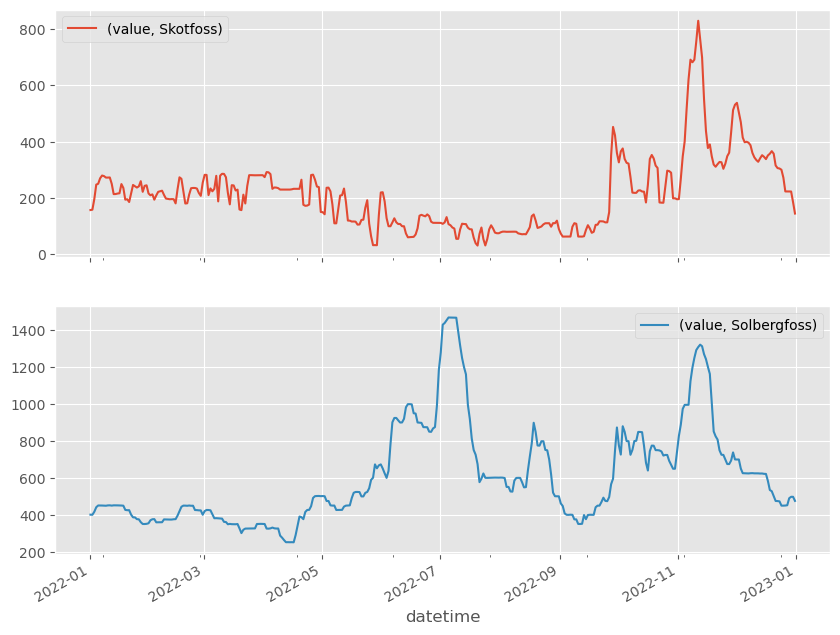

In [21]:
# Plot raw
q_df2 = q_df[["datetime", "value", "station_name"]]
q_df2.set_index(["datetime", "station_name"], inplace=True)
q_df2 = q_df2.unstack("station_name")

# Plot
q_df2.plot(subplots=True, sharex=True, figsize=(10, 8))

The code below uses the function defined above to process data from HydAPI. The only difference is that this time I'm using it with data that hasn't finished QC.

In [22]:
hydapi_q_df = process_hydapi_data_for_resa(resa_nve_df, q_df, eng)
hydapi_q_df.head()

No data for NVE ID 12.285.0.
No data for NVE ID 21.11.0.
No data for NVE ID 15.61.0.
No data for NVE ID 121.22.0.
No data for NVE ID 212.11.0.
No data for NVE ID 151.28.0.
No data for NVE ID 28.7.0.
No data for NVE ID 62.5.0.


,dis_station_id,xdate,xvalue,xcomment
0,59.0,2022-01-01,166.9264,NaN
1,59.0,2022-01-02,168.2565,NaN
2,59.0,2022-01-03,206.2556,NaN
3,59.0,2022-01-04,257.2379,NaN
4,59.0,2022-01-05,260.3433,NaN


array([<Axes: xlabel='xdate'>, <Axes: xlabel='xdate'>], dtype=object)

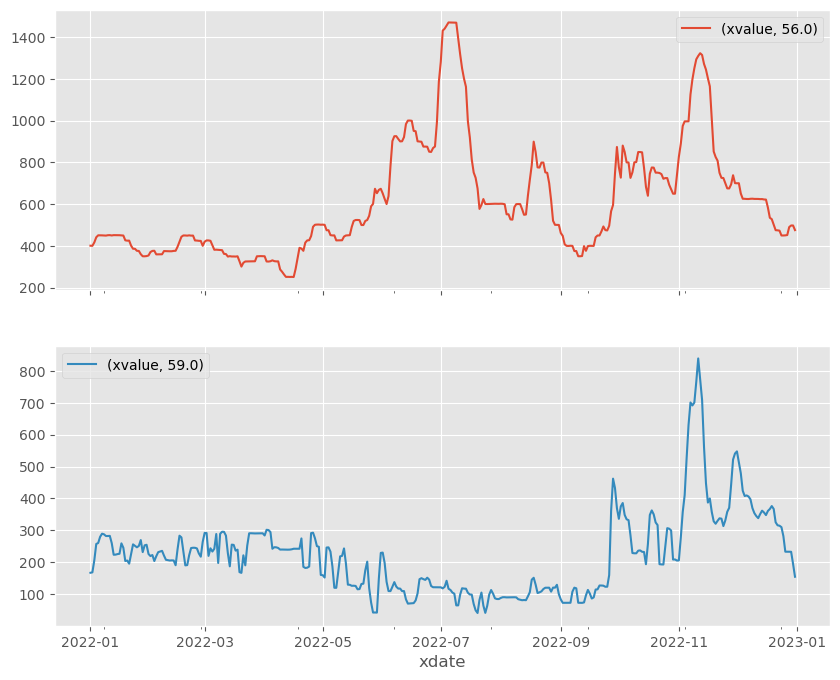

In [23]:
# Plot processed
q_df2 = hydapi_q_df[["xdate", "xvalue", "dis_station_id"]]
q_df2.set_index(["xdate", "dis_station_id"], inplace=True)
q_df2 = q_df2.unstack("dis_station_id")

# Plot
q_df2.plot(subplots=True, sharex=True, figsize=(10, 8))

In [24]:
# # Add new rows to database
# hydapi_q_df.to_sql(
#     "discharge_values", con=eng, schema="resa2", if_exists="append", index=False
# )

730